Просто возьмём семинарский ноутбук и напишем то небольшое число строк, которое требуют. В одном месте только потребовалось в уже реализованной функции указать allow_input_downcast = True. $\varepsilon$ сделаем побольше, чтобы вначале exploration был нормальным, но будем быстрее уменьшать раз в пять итераций

In [1]:
! /home/gipsokarton/miniconda/envs/py34/bin/pip install theano==0.7

In [2]:
! conda install -c https://conda.anaconda.org/kne pybox2d --yes

Fetching package metadata: ......
Solving package specifications: .........

# All requested packages already installed.
# packages in environment at /home/gipsokarton/miniconda/envs/py34:
#
pybox2d                   2.3.1post2               py34_0    kne


In [120]:
%env THEANO_FLAGS='floatX=float32'
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1



env: THEANO_FLAGS='floatX=float32'


In [121]:
import gym
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

[2018-01-29 20:45:00,758] Making new env: LunarLander-v2


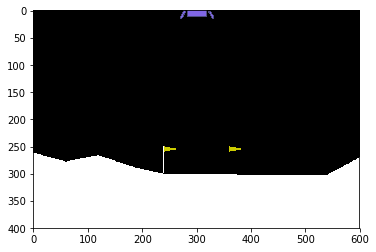

In [122]:
env = gym.make("LunarLander-v2")
env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape
plt.imshow(env.render("rgb_array"))

In [123]:
import lasagne
from lasagne.layers import *
import theano
import theano.tensor as T

#create input variables. We'll support multiple states at once


current_states = T.matrix("states[batch,units]")
actions = T.ivector("action_ids[batch]")
rewards = T.vector("rewards[batch]")
next_states = T.matrix("next states[batch,units]")
is_end = T.ivector("vector[batch] where 1 means that session just ended")

In [124]:


#input layer
l_states = InputLayer((None,)+state_dim)


#<Your architecture. Please start with a single-layer network>
l_hidden = DenseLayer(l_states, 100)

#output layer
l_qvalues = DenseLayer(l_hidden, num_units=n_actions,nonlinearity=None)

In [125]:
#get q-values for ALL actions in current_states
predicted_qvalues = get_output(l_qvalues,{l_states:current_states})

In [126]:
#compiling agent's "GetQValues" function
get_qvalues = theano.function([current_states], predicted_qvalues, allow_input_downcast=True)
#<compile a function that takes current_states and returns predicted_qvalues>

In [127]:
#select q-values for chosen actions
predicted_qvalues_for_actions = predicted_qvalues[T.arange(actions.shape[0]),actions]

In [128]:
#predict q-values for next states
predicted_next_qvalues = get_output(l_qvalues,{l_states:next_states})


#Computing target q-values under 
gamma = 0.99
target_qvalues_for_actions = rewards + gamma * predicted_next_qvalues.max(axis=1)

#zero-out q-values at the end
target_qvalues_for_actions = (1-is_end)*target_qvalues_for_actions

#don't compute gradient over target q-values (consider constant)
target_qvalues_for_actions = theano.gradient.disconnected_grad(target_qvalues_for_actions)

In [129]:
#mean squared error loss function
loss = ((target_qvalues_for_actions - predicted_qvalues_for_actions)**2).mean()


In [130]:
#all network weights
all_weights = get_all_params(l_qvalues,trainable=True)

#network updates. Note the small learning rate (for stability)
updates = lasagne.updates.sgd(loss,all_weights,learning_rate=1e-4)

In [131]:
#Training function that resembles agent.update(state,action,reward,next_state) 
#with 1 more argument meaning is_end
train_step = theano.function([current_states,actions,rewards,next_states,is_end],
                             updates=updates, allow_input_downcast=True)

In [132]:
epsilon = 0.7 #initial epsilon

def generate_session(t_max=1000):
    """play env with approximate q-learning agent and train it at the same time"""
    
    total_reward = 0
    s = env.reset()
    
    for t in range(t_max):
        
        #get action q-values from the network
        q_values = get_qvalues([s])[0] 
        
        a = q_values.argmax()
        if np.random.random() < epsilon:
            a = np.random.randint(0, n_actions)
        #a = <sample action with epsilon-greedy strategy>
        
        new_s,r,done,info = env.step(a)
        
        #train agent one step. Note that we use one-element arrays instead of scalars 
        #because that's what function accepts.
        train_step([s],[a],[r],[new_s],[done])
        
        total_reward+=r
        
        s = new_s
        if done: break
            
    return total_reward

In [133]:
for i in range(29):
    
    rewards = [generate_session() for _ in range(100)] #generate new sessions
    
    if i% 5 == 4:
        epsilon*=0.6
    
    print ("mean reward:%.3f\tepsilon:%.5f"%(np.mean(rewards),epsilon))

    if np.mean(rewards) > 300:
        print ("You Win!")
        break
        
    assert epsilon!=0, "Please explore environment"


mean reward:-236.754	epsilon:0.70000
mean reward:-211.452	epsilon:0.70000
mean reward:-223.412	epsilon:0.70000
mean reward:-217.201	epsilon:0.70000
mean reward:-177.073	epsilon:0.42000
mean reward:-227.835	epsilon:0.42000
mean reward:-231.992	epsilon:0.42000
mean reward:-196.155	epsilon:0.42000
mean reward:-159.974	epsilon:0.42000
mean reward:-126.837	epsilon:0.25200
mean reward:-125.167	epsilon:0.25200
mean reward:-122.763	epsilon:0.25200
mean reward:-72.183	epsilon:0.25200
mean reward:-40.103	epsilon:0.25200
mean reward:-46.813	epsilon:0.15120
mean reward:-81.194	epsilon:0.15120
mean reward:-115.417	epsilon:0.15120
mean reward:-137.747	epsilon:0.15120
mean reward:-55.413	epsilon:0.15120
mean reward:-53.032	epsilon:0.09072
mean reward:-30.231	epsilon:0.09072
mean reward:13.222	epsilon:0.09072
mean reward:-1.473	epsilon:0.09072
mean reward:49.774	epsilon:0.09072
mean reward:37.517	epsilon:0.05443
mean reward:39.622	epsilon:0.05443
mean reward:90.634	epsilon:0.05443
mean reward:7.162	ep

Средний счёт за последние 5 итераций больше нуля (что, вроде, примерно и требовалось). На этом и остановимся

In [134]:
epsilon=0 #Don't forget to reset epsilon back to initial value if you want to go on training

In [135]:
#record sessions
import gym.wrappers
env = gym.wrappers.Monitor(env,directory="videos",force=True)
sessions = [generate_session() for _ in range(100)]
env.close()
#unwrap 
env = env.env.env
#upload to gym
#gym.upload("./videos/",api_key="<your_api_key>") #you'll need me later

#Warning! If you keep seeing error that reads something like"DoubleWrapError",
#run env=gym.make("CartPole-v0");env.reset();

[2018-01-29 21:16:57,511] Clearing 12 monitor files from previous run (because force=True was provided)
[2018-01-29 21:16:57,630] Starting new video recorder writing to /home/gipsokarton/mipt_ml_dz/videos/openaigym.video.2.5690.video000000.mp4
[2018-01-29 21:17:11,122] Starting new video recorder writing to /home/gipsokarton/mipt_ml_dz/videos/openaigym.video.2.5690.video000001.mp4
[2018-01-29 21:17:16,175] Starting new video recorder writing to /home/gipsokarton/mipt_ml_dz/videos/openaigym.video.2.5690.video000008.mp4
[2018-01-29 21:17:50,051] Starting new video recorder writing to /home/gipsokarton/mipt_ml_dz/videos/openaigym.video.2.5690.video000027.mp4
[2018-01-29 21:18:21,456] Starting new video recorder writing to /home/gipsokarton/mipt_ml_dz/videos/openaigym.video.2.5690.video000064.mp4
[2018-01-29 21:18:59,988] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/gipsokarton/mipt_ml_dz/videos')


In [142]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1])) #this may or may not be _last_ video. Try other indices